# Triage Agent

Gather a high-level overview of the cluster's health and identify potential problem areas.

### Deterministic data gathering

- **Pod Status Check**:
    - `Tool`: `K8sAPI.get_problematic_pods()`
    - `Output`: Pods with pending states, container errors, high restarts (>3)
- **Trace Analysis**:
    - `Tool`: `JaegerAPI.get_processed_traces()` and `JaegerAPI.get_slow_traces()`
    - `Output`: Traces with errors or high latency, including service sequences
- **Metrics Analysis**:
    - `Tool`: `PrometheusAPI.get_pod_triage_metrics()`
    - `Output`: Pods with thread saturation (>95%), high CPU load (>10.0), or network errors

In [17]:
from dotenv import load_dotenv
import os
# Get the path to the root directory of the repository
root_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))

# Load environment variables from .env file in the root directory
load_dotenv(os.path.join(root_dir, '.env'), verbose=True)

True

In [18]:
import sys

# Add MCP-server to path
mcp_server_path = os.path.abspath(os.path.join(os.getcwd(), '../../MCP-server'))
sys.path.insert(0, mcp_server_path)

## Build the agent

In [19]:
from pydantic import BaseModel, Field
from typing import List, Literal

class Symptom(BaseModel):
    """A symptom observed in the Kubernetes cluster"""
    potential_symptom: str = Field(..., description="Type of symptom observed")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource experiencing the issue")
    affected_resource: str = Field(..., description="Exact name of the resource experiencing the issue (no namespace or decorators)")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

class SymptomList(BaseModel):
    """A list of symptoms observed in the Kubernetes cluster"""
    symptoms: List[Symptom] = Field(default_factory=list, description="List of symptoms observed in the cluster")

In [20]:
from typing import TypedDict, List, Literal, Annotated

class TriageAgentState(TypedDict):
    app_name: str
    app_summary: str
    target_namespace: str
    trace_service_starting_point: str
    problematic_pods: dict
    problematic_traces: dict
    slow_traces: dict
    problematic_metrics: dict
    symptoms: List[Symptom]

In [21]:
from api.jaeger_api import JaegerAPI
from api.k8s_api import K8sAPI
from api.prometheus_api import PrometheusAPI

def get_triage_data(state: TriageAgentState):
    """Get triage data from cluster"""

    jaeger_api = JaegerAPI()
    k8s_api = K8sAPI(state["target_namespace"])
    prometheus_api = PrometheusAPI(namespace=state["target_namespace"])
    
    # Get pods with problematic statuses
    problematic_pods = k8s_api.get_problematic_pods()

    # Traces which have errors
    problematic_traces = jaeger_api.get_processed_traces(service=state["trace_service_starting_point"], only_errors=True)

    # Filtern for traces whxich take more than 2 seconds
    slow_traces = jaeger_api.get_slow_traces(service=state["trace_service_starting_point"], min_duration_ms=2000)

    # Metrics with anomalous values
    problematic_pods_metrics = {}
    problematic_pods_metrics["problematic_metrics"] = []

    pods = k8s_api.get_pods_list()

    for pod in pods:
        triage_metric_report = prometheus_api.get_pod_triage_metrics(pod)
        if triage_metric_report["is_anomalous"]:
            problematic_pods_metrics["problematic_metrics"].append(triage_metric_report)
    
    if(len(problematic_pods_metrics["problematic_metrics"])>0):
        problematic_pods_metrics["pods_count"] = len(problematic_pods_metrics["problematic_metrics"])
    else:
        problematic_pods_metrics["info"] = "All monitored metrics look healthy; no anomalous values detected."

    return {
        "problematic_pods": problematic_pods,
        "problematic_traces": problematic_traces,
        "slow_traces": slow_traces,
        "problematic_metrics": problematic_pods_metrics
    }

In [22]:
from pydantic import BaseModel, Field
from typing import List

class Symptom(BaseModel):
    """
    A symptom observed in the Kubernetes cluster
    """
    potential_symptom: str = Field(..., description="Type of symptom observed")
    resource_type: Literal["pod", "service"] = Field(..., description="Type of resource experiencing the issue")
    affected_resource: str = Field(..., description="Name of the resource experiencing the issue")
    evidence: str = Field(..., description="Evidence supporting this symptom identification")

class SymptomList(BaseModel):
    """
    A list of symptoms observed in the Kubernetes cluster
    """
    symptoms: List[Symptom] = Field(default_factory=list, description="List of symptoms observed in the cluster")

In [23]:
from langchain_openai import ChatOpenAI

gpt5mini = ChatOpenAI(model="gpt-5-mini")

llm_for_symptoms = gpt5mini.with_structured_output(SymptomList)

In [24]:
import json
from langchain_core.prompts import ChatPromptTemplate

app_summary = "The application is a hotel reservation system with a microservices architecture. The 'frontend' service is the entry point for user requests."

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert Site Reliability Engineer. Your mission is to triage a Kubernetes application by analyzing the provided data.

Your analysis must adhere to the following rules:
1.  **Focus**: Identify symptoms at the **pod or service level only**. Do not provide cluster-wide analysis or generalizations.
2.  **Aggregation**: For each pod or service that has issues, create **at most one symptom entry**. Aggregate all related evidence (from pods, metrics, traces) into that single entry.
3.  **Action**: Synthesize the information to identify and list potential symptoms. For each symptom, pinpoint the affected resource (pod or service) and cite the specific evidence.
4.  **Empty State**: If the provided data contains no issues, it is correct to return an empty list of symptoms.""",
        ),
        ("human", "{human_input}"),
    ]
)

In [25]:
def triage_agent(state: TriageAgentState):
    human_prompt_parts = [
    f"Please analyze the following triage data for the {state["app_name"]} application.\n\n### Application Summary\n{state["app_summary"]}"
    ]

    if "info" not in state["problematic_pods"]:
        problematic_pods_str = json.dumps(state["problematic_pods"], indent=2)
        human_prompt_parts.append(f"### Problematic Pods\n```json\n{problematic_pods_str}\n```")

    if "info" not in state["problematic_metrics"]:
        problematic_metrics_str = json.dumps(state["problematic_metrics"], indent=2)
        human_prompt_parts.append(f"### Anomalous Pod Metrics\n```json\n{problematic_metrics_str}\n```")

    if "info" not in state["problematic_traces"] and "error" not in state["problematic_traces"]:
        problematic_traces_str = json.dumps(state["problematic_traces"], indent=2)
        human_prompt_parts.append(f"### Error Traces\n```json\n{problematic_traces_str}\n```")

    if "info" not in state["slow_traces"] and "error" not in state["slow_traces"]:
        slow_traces_str = json.dumps(state["slow_traces"], indent=2)
        human_prompt_parts.append(f"### Slow Traces\n```json\n{slow_traces_str}\n```")
    
    # If no problems were found in any dataset, add a note.
    if len(human_prompt_parts) == 1:
        human_prompt_parts.append("No issues were found in pods, metrics, or traces.")

    human_input = "\n\n".join(human_prompt_parts)

    triage_chain = prompt_template | llm_for_symptoms

    symptom_list = triage_chain.invoke({
        "human_input" : human_input
    })

    return {"symptoms" : symptom_list.symptoms} #type: ignore

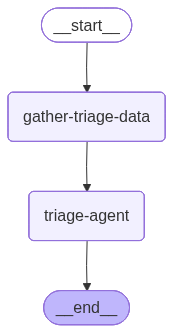

In [26]:
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display

# Build the graph
builder = StateGraph(TriageAgentState)

# Add nodes
builder.add_node("gather-triage-data", get_triage_data)
builder.add_node("triage-agent", triage_agent)

# Add edges
builder.add_edge(START,"gather-triage-data")
builder.add_edge("gather-triage-data", "triage-agent")
builder.add_edge("triage-agent", END)

triage_agent = builder.compile()

display(Image(triage_agent.get_graph(xray=True).draw_mermaid_png()))

In [27]:
import time

def run_triage_agent(graph, app_summary:str, target_namespace: str, trace_service_starting_point: str, trace_name: str | None = None):
    """Test the structured graph with SREAgentState"""
    # Create initial state with SREAgentState structure
    initial_state = {
        "app_name" : "Hotel reservation",
        "app_summary" : app_summary,
        "target_namespace": target_namespace,
        "trace_service_starting_point": trace_service_starting_point,
        "problematic_pods": {},
        "problematic_traces": {},
        "slow_traces": {},
        "problematic_metrics": {},
        "symptoms": []
    }
    
    # Start time tracking
    start_time = time.time()

    # Configuration for the graph execution
    config = {"recursion_limit": 50}
    if trace_name:
        config["run_name"] = trace_name # type: ignore
    
    # Invoke the graph
    symptoms = graph.invoke(initial_state, config)

    # Calculate execution time
    execution_time = time.time() - start_time

    return symptoms, execution_time

In [28]:
experiment_name = input("Enter experiment name: ")

if experiment_name.strip() == "":
    experiment_name = "Triage agent"

In [29]:
app_summary = """
    The application implements a hotel reservation service, build with Go and gRPC. The initial project is extended in several ways, including adding back-end in-memory and persistent databases, adding a recommender system for obtaining hotel recommendations, and adding the functionality to place a hotel reservation. 
"""
target_namespace = "test-hotel-reservation"
service_starting_point = "frontend"

In [30]:
final_state, execTime = run_triage_agent(
    graph=triage_agent,
    app_summary=app_summary,
    target_namespace=target_namespace,
    trace_service_starting_point=service_starting_point,
    trace_name=experiment_name
)

In [31]:
potential_symptoms = final_state["symptoms"]

for i, symptom in enumerate(potential_symptoms):
    print(f"\n ### Symptom {i+1} ###\nPotential symptom: {symptom.potential_symptom}\nAffected {symptom.resource_type}: {symptom.affected_resource}\nEvidence: {symptom.evidence}\n")


 ### Symptom 1 ###
Potential symptom: Container in CrashLoopBackOff (repeated restarts)
Affected pod: geo-6b4b89b5f5-rsrh7
Evidence: Namespace: test-hotel-reservation; container=hotel-reserv-geo is in Waiting state with reason=CrashLoopBackOff; message='back-off 5m0s restarting failed container=hotel-reserv-geo pod=geo-6b4b89b5f5-rsrh7_test-hotel-reservation(...)'; restart_count=54.


 ### Symptom 2 ###
Potential symptom: Frontend RPC failures to search service (Unavailable)
Affected service: search
Evidence: Traces from service 'frontend' (traces_count=20) show repeated errors in sequence 'frontend -> search' with has_error=true and error_message='rpc error: code = Unavailable desc = there is no connection available' (seen across many traceIDs, latencies ~0.5–1.2ms), indicating the search service is returning/experiencing Unavailable connection errors.



In [32]:
final_state["symptoms"]

[Symptom(potential_symptom='Container in CrashLoopBackOff (repeated restarts)', resource_type='pod', affected_resource='geo-6b4b89b5f5-rsrh7', evidence="Namespace: test-hotel-reservation; container=hotel-reserv-geo is in Waiting state with reason=CrashLoopBackOff; message='back-off 5m0s restarting failed container=hotel-reserv-geo pod=geo-6b4b89b5f5-rsrh7_test-hotel-reservation(...)'; restart_count=54."),
 Symptom(potential_symptom='Frontend RPC failures to search service (Unavailable)', resource_type='service', affected_resource='search', evidence="Traces from service 'frontend' (traces_count=20) show repeated errors in sequence 'frontend -> search' with has_error=true and error_message='rpc error: code = Unavailable desc = there is no connection available' (seen across many traceIDs, latencies ~0.5–1.2ms), indicating the search service is returning/experiencing Unavailable connection errors.")]